# Python Notebook for Parameter Estimation of a Lettuce Growth Model
This notebook implements the steps for estimating a subset of parameters for the lettuce growth model. The process involves generating synthetic data, adding noise to simulate experimental measurements, and then using optimization techniques to recover the original parameters.

## 1. Import libraries

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, least_squares
import matplotlib.pyplot as plt



## 2. Implement the Lettuce ODE Model
This function defines the system of ordinary differential equations for lettuce growth.

In [2]:
def lettuce_ode(t, X, params, inputs):
    """
    Lettuce growth model.

    Args:
        t: Current time (required by ODE solvers)
        X: State vector [X_nsdw, X_sdw] (g m^-2)
        params: Dictionary containing model parameters
        inputs: Dictionary containing environmental inputs

    Returns:
        dXdt: Column vector of derivatives [dX_nsdw/dt, dX_sdw/dt]
    """
    X_nsdw = X[0]  # Non-structural dry weight (g m^-2)
    X_sdw = X[1]   # Structural dry weight (g m^-2)

    # Parameters
    c_alpha = params['c_alpha']
    c_beta = params['c_beta']
    c_gr_max = params['c_gr_max']
    c_gamma = params['c_gamma']
    c_Q10_gr = params['c_Q10_gr']
    c_resp_sht = params['c_resp_sht']
    c_resp_rt = params['c_resp_rt']
    c_tau = params['c_tau']
    c_Q10_resp = params['c_Q10_resp']
    c_K = params['c_K']
    c_lar = params['c_lar']
    c_epsilon = params['c_epsilon']
    c_Gamma = params['c_Gamma']
    c_10_Gamma = params['c_10_Gamma']
    c_bnd = params['c_bnd']
    c_stm = params['c_stm']
    c_car1 = params['c_car1']
    c_car2 = params['c_car2']
    c_car3 = params['c_car3']
    c_w = params['c_w']

    # Inputs
    U_PAR = inputs['U_PAR'] # Incident PAR (W m^-2)
    U_CO2 = inputs['U_CO2'] # CO2 concentration (ppm)
    U_T = inputs['U_T']     # Canopy temperature (degrees C)

    # Intermediate calculations
    # epsilon
    Gamma = c_Gamma * c_10_Gamma**((U_T - 20) / 10)
    if U_CO2 + 2 * Gamma <= 0: # prevents division by zero
        epsilon = 0
    else:
        epsilon = c_epsilon * (U_CO2 - Gamma) / (U_CO2 + 2 * Gamma)
    epsilon = max(0, epsilon) # cannot be negative

    # Carboxylation conductance (1/g_CO2)
    c_car = c_car1 * U_T**2 + c_car2 * U_T + c_car3
    c_car = max(np.finfo(float).eps, c_car)

    g_CO2_inv = (1 / max(np.finfo(float).eps, c_bnd)) + \
                (1 / max(np.finfo(float).eps, c_stm)) + \
                (1 / max(np.finfo(float).eps, c_car))
    g_CO2 = 1 / g_CO2_inv

    # f_phot_max
    phot_denom = epsilon * U_PAR + g_CO2 * c_w * (U_CO2 - Gamma)
    if phot_denom <= 0:
        f_phot_max = 0
    else:
        f_phot_max = (epsilon * U_PAR * g_CO2 * c_w * (U_CO2 - Gamma)) / phot_denom
    f_phot_max = max(0, f_phot_max) # cannot be negative

    # f_phot
    f_phot = (1 - np.exp(-c_K * c_lar * (1 - c_tau) * X_sdw)) * f_phot_max

    # r_gr
    growth_denom = c_gamma * X_sdw + X_nsdw
    if growth_denom <= 0 or X_nsdw < 0:
        r_gr = 0
    else:
        r_gr = c_gr_max * (X_nsdw / growth_denom) * c_Q10_gr**((U_T - 20) / 10)
    r_gr = max(0, r_gr) # cannot be negative

    # f_resp
    f_resp = (c_resp_sht * (1 - c_tau) * X_sdw + c_resp_rt * c_tau * X_sdw) * \
             c_Q10_resp**((U_T - 25) / 10)
    f_resp = max(0, f_resp) # cannot be negative

    # dX_nsdw/dt
    dX_nsdw_dt = c_alpha * f_phot - r_gr * X_sdw - f_resp - \
                 ((1 - c_beta) / c_beta) * r_gr * X_sdw

    # dX_sdw/dt
    dX_sdw_dt = r_gr * X_sdw

    return [dX_nsdw_dt, dX_sdw_dt]


## 3. Load True Parameters
This function loads the true value of the parameters (provided by the paper of Van Henten, E. J. (1994) "Sensitivity analysis of a dynamic growth model of lettuce")

In [3]:
def load_true_parameters():
    """Returns a dictionary of the true model parameters."""
    params = {}
    params['c_alpha']      = 0.68
    params['c_beta']       = 0.8
    params['c_gr_max']     = 5.0e-6
    params['c_gamma']      = 1.0
    params['c_Q10_gr']     = 1.6
    params['c_resp_sht']   = 3.47e-7
    params['c_resp_rt']    = 1.16e-7
    params['c_tau']        = 0.07
    params['c_Q10_resp']   = 2.0
    params['c_K']          = 0.9
    params['c_lar']        = 75.0e-3
    params['c_epsilon']    = 17.0e-6
    params['c_Gamma']      = 40.0
    params['c_10_Gamma']   = 2.0
    params['c_bnd']        = 0.004
    params['c_stm']        = 0.02
    params['c_car1']       = -1.32e-5
    params['c_car2']       = 5.94e-4
    params['c_car3']       = -2.64e-3
    params['c_w']          = 7.32e-3
    return params

true_params = load_true_parameters()
print("True Parameters:", true_params)

True Parameters: {'c_alpha': 0.68, 'c_beta': 0.8, 'c_gr_max': 5e-06, 'c_gamma': 1.0, 'c_Q10_gr': 1.6, 'c_resp_sht': 3.47e-07, 'c_resp_rt': 1.16e-07, 'c_tau': 0.07, 'c_Q10_resp': 2.0, 'c_K': 0.9, 'c_lar': 0.075, 'c_epsilon': 1.7e-05, 'c_Gamma': 40.0, 'c_10_Gamma': 2.0, 'c_bnd': 0.004, 'c_stm': 0.02, 'c_car1': -1.32e-05, 'c_car2': 0.000594, 'c_car3': -0.00264, 'c_w': 0.00732}



 ## 4. Define Input Conditions


In [4]:

inputs = {
    'U_PAR': 150,  # Incident PAR (W m^-2) 
    'U_CO2': 600,  # CO2 concentration (ppm) 
    'U_T':   22    # Canopy temperature (degrees) 
}
print("Inputs:", inputs)

Inputs: {'U_PAR': 150, 'U_CO2': 600, 'U_T': 22}


 ## 5. Synthetic Data Generation
 
* "True" data for $X_{nsdw}$ and $X_{sdw}$ were generated by solving the ODE model using the values of the parameters and input defined above.
* The `scipy.integrate.solve_ivp` function was used for ODE integration.


Simulation for 40 days.
Sampling on days: [ 0  4  8 12 16 20 24 28 32 36 40]


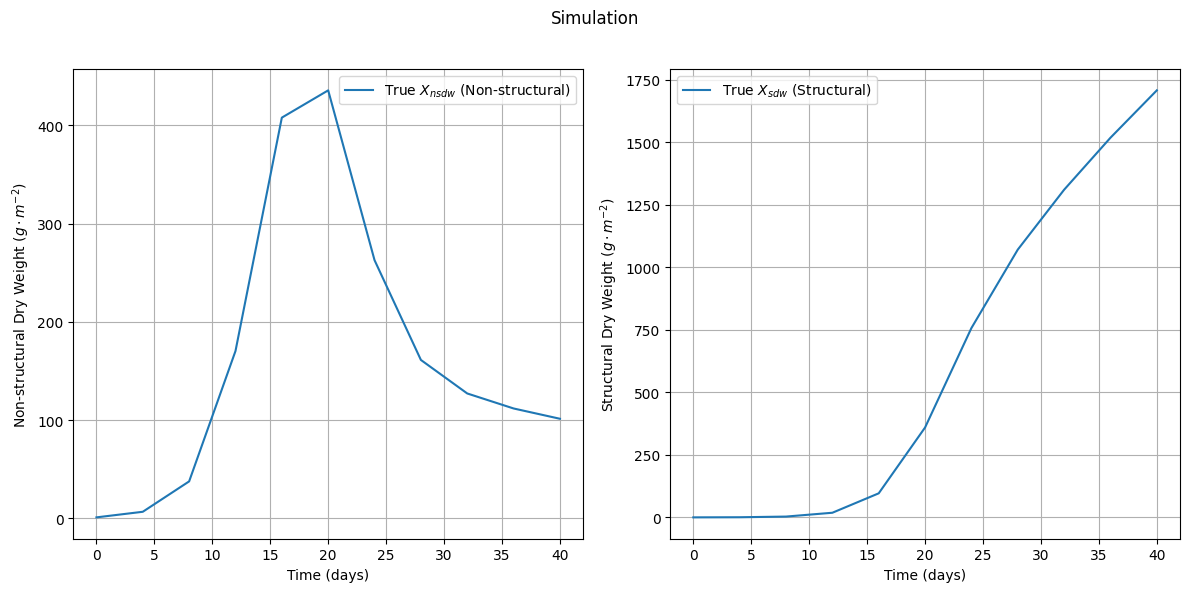

In [5]:

# Initial conditions for state variables [X_nsdw, X_sdw]
X0 = [1.0, 0.1]  #1g/m^2 non-structural, 0.1g/m^2 structural

# Time span for the simulation
t_days = 40

t_seconds_per_day = 24 * 60 * 60

# Suppose we sample the data every 4 days.
sampling_interval_days = 4
num_sampling_points = int(t_days / sampling_interval_days) + 1
sampling_days = np.linspace(0, sampling_interval_days * (num_sampling_points - 1), num_sampling_points)
sampling_days = np.arange(0, t_days + 1, sampling_interval_days)

t_eval_seconds = sampling_days * t_seconds_per_day

t_span_seconds = [0, t_days * t_seconds_per_day]

print(f"Simulation for {t_days} days.")
print(f"Sampling on days: {sampling_days}")

# Solve the ODE
sol_true = solve_ivp(
    fun=lettuce_ode,
    t_span=t_span_seconds,
    y0=X0,
    args=(true_params, inputs),
    t_eval=t_eval_seconds,
    method='RK45' # explicit solver commonly used for ODEs
)

# Extract data
true_X_nsdw = sol_true.y[0, :]
true_X_sdw = sol_true.y[1, :]
time_points_days = t_eval_seconds / t_seconds_per_day

# Plot data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(time_points_days, true_X_nsdw, label='True $X_{nsdw}$ (Non-structural)')
plt.xlabel('Time (days)')
plt.ylabel('Non-structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_points_days, true_X_sdw, label='True $X_{sdw}$ (Structural)')
plt.xlabel('Time (days)')
plt.ylabel('Structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.grid(True)

plt.suptitle('Simulation')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 6. Perturb Data to Simulate a Realistic Scenario

The noise level should scale with the true data's magnitude, to have this the noise is added using a **Coefficient of Variation (CV)** since is more realistic than fixed absolute noise.
The Coefficient of Variation is the standard deviation divided by the mean ($CV = \sigma / \mu$), representing relative error.
* The standard deviation of the noise at each time point ($\sigma_{noise}$) is calculated as:
    $$\sigma_{noise} = CV \times \text{True Data Value}$$

* We've chosen:
    * `cv_nsdw = 0.15` 15% for Non-Structural Dry Weight.
    * `cv_sdw = 0.15` 15% for Structural Dry Weight.


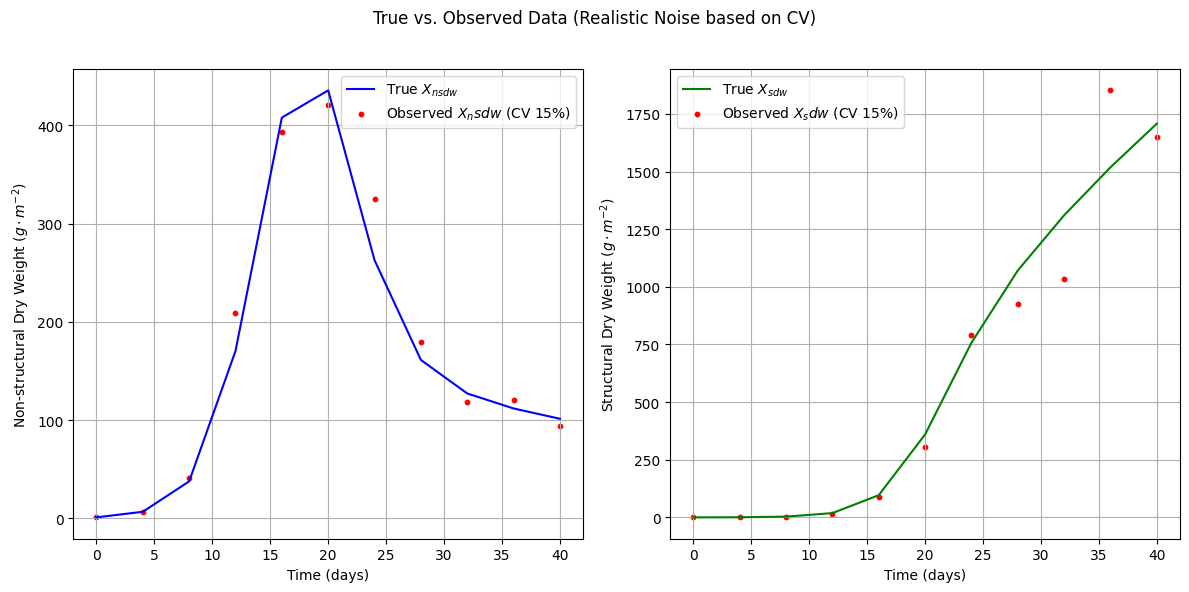

In [6]:
# CV = standard_deviation / mean
# So, standard_deviation_of_noise = CV * true_value
cv_nsdw = 0.15  
cv_sdw = 0.15  

np.random.seed(42)

# Calculate standard deviation of noise at each time point
noise_std_dev_nsdw = cv_nsdw * true_X_nsdw
noise_std_dev_sdw = cv_sdw * true_X_sdw

# Generate noise values from a normal distribution with mean 0 and calculated std dev
noise_values_nsdw = np.random.normal(0, noise_std_dev_nsdw, size=true_X_nsdw.shape)
noise_values_sdw = np.random.normal(0, noise_std_dev_sdw, size=true_X_sdw.shape)

# Add noise 
observed_X_nsdw = true_X_nsdw + noise_values_nsdw
observed_X_sdw = true_X_sdw + noise_values_sdw

observed_X_nsdw = np.maximum(0, observed_X_nsdw)
observed_X_sdw = np.maximum(0, observed_X_sdw) 

# Plot true VS observed data 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(time_points_days, true_X_nsdw, label='True $X_{nsdw}$', linestyle='-', color='blue')
plt.scatter(time_points_days, observed_X_nsdw, label=f'Observed $X_nsdw$ (CV {cv_nsdw*100:.0f}%)', color='red', s=10)
plt.xlabel('Time (days)')
plt.ylabel('Non-structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_points_days, true_X_sdw, label='True $X_{sdw}$', linestyle='-', color='green')
plt.scatter(time_points_days, observed_X_sdw, label=f'Observed $X_sdw$ (CV {cv_sdw*100:.0f}%)', color='red', s=10)
plt.xlabel('Time (days)')
plt.ylabel('Structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.grid(True)

plt.suptitle('True vs. Observed Data (Realistic Noise based on CV)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



 ## 7. Define the Objective Function
 
    
*    Residual function:
$$ \text{r}_i = y_{sim}(t_i, \theta_p) - y_{obs}(t_i) $$
   
* Objective function:
$$ J(\theta_p) = \sum_{i=1}^{N} \left( (X_{nsdw,sim}(t_i, \theta_p) - X_{nsdw,obs}(t_i))^2 + (X_{sdw,sim}(t_i, \theta_p) - X_{sdw,obs}(t_i))^2 \right) $$
where $N$ is the number of observation time points. 

In [ ]:
parameters_to_estimate_names = ['c_alpha', 'c_beta', 'c_resp_sht', 'c_gr_max'] 

current_params_for_estimation = true_params.copy()

def objective_function(estimated_param_values, param_names_to_estimate, all_params,
                       t_eval_seconds, X0_sim, inputs_sim, observed_nsdw, observed_sdw):
    """
    It runs the model with current parameter guesses and returns the sum of squared errors.
    """
    params_to_simulate = all_params.copy()
    for i, name in enumerate(param_names_to_estimate):
        params_to_simulate[name] = estimated_param_values[i]

    # Run the ODE solver with the updated parameters
    sol_estimated = solve_ivp(
        fun=lettuce_ode,
        t_span=[t_eval_seconds[0], t_eval_seconds[-1]],
        y0=X0_sim,
        args=(params_to_simulate, inputs_sim),
        t_eval=t_eval_seconds,
        method='RK45'
    )

    if not sol_estimated.success or sol_estimated.y.shape[1] != len(t_eval_seconds):
        print(f"Solver failed, params: {estimated_param_values}")
        return np.inf

    sim_X_nsdw = sol_estimated.y[0, :]
    sim_X_sdw = sol_estimated.y[1, :]

    # Calculate the error 
    error_nsdw = np.sum((sim_X_nsdw - observed_nsdw)**2)
    error_sdw = np.sum((sim_X_sdw - observed_sdw)**2)
    
    total_error = error_nsdw + error_sdw
    
    # print(f"params: {dict(zip(param_names_to_estimate, estimated_param_values))}, SSE: {total_error}")
    return total_error


def residuals_function(estimated_param_values, param_names_to_estimate, all_params,
                       t_eval_seconds, X0_sim, inputs_sim, observed_nsdw, observed_sdw):
    """
    Residuals function for `least_squares` optimization.
    Returns a flat array of residuals (simulated - observed).
    """
    params_to_simulate = all_params.copy()
    for i, name in enumerate(param_names_to_estimate):
        params_to_simulate[name] = estimated_param_values[i]

    sol_estimated = solve_ivp(
        fun=lettuce_ode,
        t_span=[t_eval_seconds[0], t_eval_seconds[-1]],
        y0=X0_sim,
        args=(params_to_simulate, inputs_sim),
        t_eval=t_eval_seconds,
        method='RK45'
    )

    if not sol_estimated.success or sol_estimated.y.shape[1] != len(t_eval_seconds):
        print(f"Solver failed or mismatched output for params: {estimated_param_values}")
        return np.full(len(observed_nsdw) + len(observed_sdw), np.inf)

    sim_X_nsdw = sol_estimated.y[0, :]
    sim_X_sdw = sol_estimated.y[1, :]

    residuals_nsdw = sim_X_nsdw - observed_nsdw
    residuals_sdw = sim_X_sdw - observed_sdw
    
    return np.concatenate([residuals_nsdw, residuals_sdw])



 ## 8. Perform Parameter Estimation

Parameter estimation was carried out using optimization algorithms available in `scipy.optimize`.

* **Minimization Algorithms**:
    Two optimization approaches from `scipy.optimize` were demonstrated:
    1.  **`least_squares` (with Trust Region Reflective method)**: can handle bounds on parameters.
    2.  **`minimize` (with 'Nelder-Mead' method)**

* **Initial Guesses and Bounds**:
    * Initial guesses for the parameters to be estimated were generated by perturbing their true values (±40%).
    * Physically plausible bounds were defined for each parameter being estimated




In [8]:

# initial guesses
initial_guesses = []
parameter_bounds = []

print(f"Estimating parameters: {parameters_to_estimate_names}")
for param_name in parameters_to_estimate_names:
    true_val = true_params[param_name]
    # Example: initial guess is 60% to 140% of the true value
    guess = true_val * (np.random.uniform(0.6, 1.4))
    initial_guesses.append(guess)
    
    # Many parameters in this model are rates or coefficients and should be non-negative.
    # Some parameters have theoretical upper limits.
    lower_bound = 0 
    if param_name == 'c_car1': # This parameter is negative 
        lower_bound = -np.inf 
        upper_bound = 0    
    elif param_name == 'c_beta' or param_name == 'c_alpha' or param_name == 'c_tau': 
        if param_name == 'c_beta':
            lower_bound = 1e-6 #avoids division by zero
        else:
            lower_bound = 0.0
        upper_bound = 1.0
    else: # Case of general positive parameters
        lower_bound = np.finfo(float).eps 
        upper_bound = true_val * 5 

    parameter_bounds.append((lower_bound, upper_bound))


print(f"Initial guesses: {dict(zip(parameters_to_estimate_names, initial_guesses))}")
print(f"Parameter bounds: {dict(zip(parameters_to_estimate_names, parameter_bounds))}")

#  Option 1: Using `scipy.optimize.minimize` with Nelder-Mead

#print("\nStarting optimization with scipy.optimize.minimize...")
#optimization_result_minimize = minimize(
#    fun=objective_function,
#    x0=initial_guesses,
#    args=(parameters_to_estimate_names, true_params.copy(), 
#          t_eval_seconds, X0, inputs, observed_X_nsdw, observed_X_sdw),
#    #method='L-BFGS-B',  # Supports bounds
#    method='Nelder-Mead', # Doesn't use bounds directly 
#    #bounds=parameter_bounds, # Only for methods that support bounds like L-BFGS-B, TNC, SLSQP
#    options={'disp': True, 'ftol': 1e-9, 'gtol': 1e-7} 
#)

# Option 2: Using `scipy.optimize.least_squares` 

print("\nStarting optimization with scipy.optimize.least_squares...")

# bounds ([lowers], [uppers])
ls_bounds = ([b[0] for b in parameter_bounds], [b[1] for b in parameter_bounds])

optimization_result_least_squares = least_squares(
    fun=residuals_function,
    x0=initial_guesses,
    args=(parameters_to_estimate_names, true_params.copy(), 
          t_eval_seconds, X0, inputs, observed_X_nsdw, observed_X_sdw),
    bounds=ls_bounds, 
    method='trf', 
    verbose=2 
)

if optimization_result_least_squares.success:
    estimated_params_ls = optimization_result_least_squares.x
    print("Optimization with least_squares successful.")
    print(f"Estimated parameters (least_squares): {dict(zip(parameters_to_estimate_names, estimated_params_ls))}")
else:
    estimated_params_ls = initial_guesses
    print("Optimization with least_squares failed or did not converge.")
    print(f"Termination status: {optimization_result_least_squares.status}")
    print(f"Message: {optimization_result_least_squares.message}")


if optimization_result_least_squares.success:
    final_estimated_param_values = estimated_params_ls
    print("\nDone.")


Estimating parameters: ['c_alpha', 'c_beta', 'c_resp_sht', 'c_gr_max']
Initial guesses: {'c_alpha': 0.5166225374941477, 'c_beta': 0.8091100405847114, 'c_resp_sht': 3.72654284316103e-07, 'c_gr_max': 3.185801650879991e-06}
Parameter bounds: {'c_alpha': (0.0, 1.0), 'c_beta': (1e-06, 1.0), 'c_resp_sht': (np.float64(2.220446049250313e-16), 1.7350000000000001e-06), 'c_gr_max': (np.float64(2.220446049250313e-16), 2.5e-05)}

Starting optimization with scipy.optimize.least_squares...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7821e+06                                    4.85e+07    
       1              2         2.8688e+05      1.50e+06       9.73e-02       1.04e+07    
       2              3         1.1483e+05      1.72e+05       1.29e-02       1.39e+06    
       3              4         1.0740e+05      7.43e+03       2.63e-02       4.61e+04    
       4              6         1.0570e+05      1.69e+03       4.


 ## 9. Visualize Results and Compare Parameters


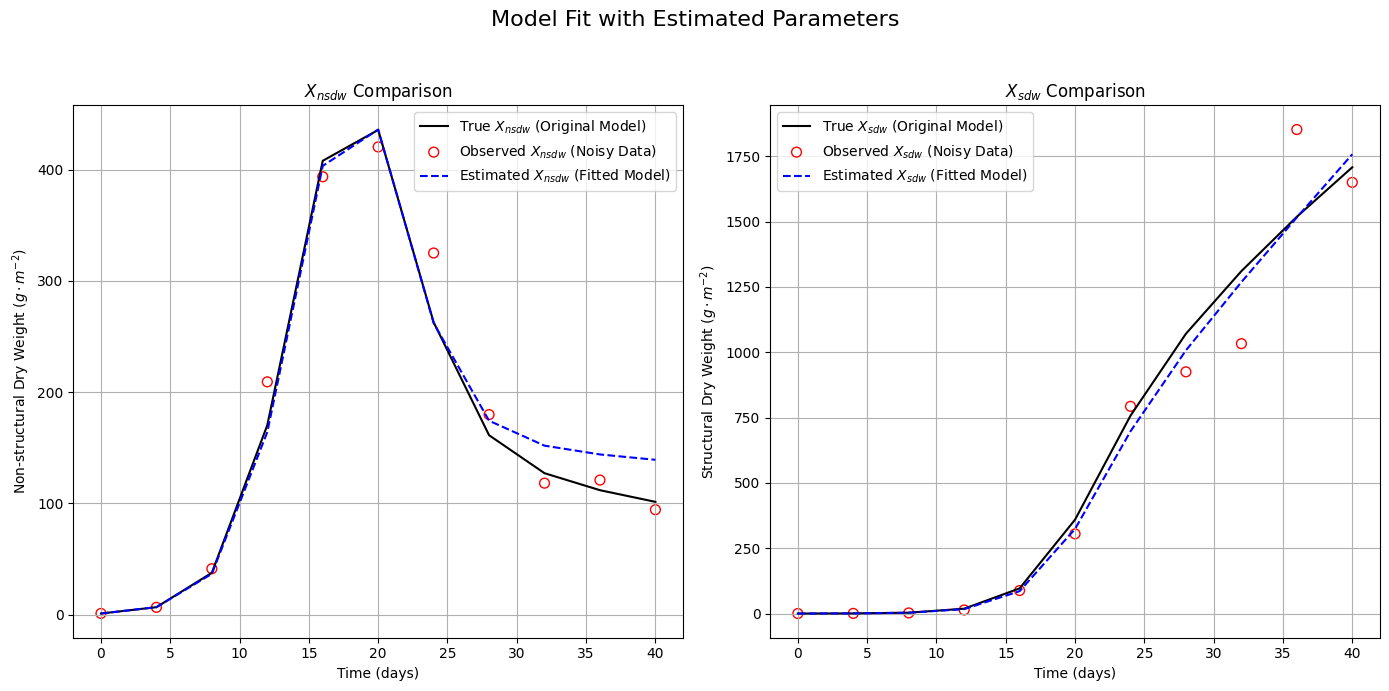


Parameter Comparison:
Parameter       | True Value      | Initial Guess   | Estimated Value     
----------------------------------------------------------------------
c_alpha         | 6.80e-01        | 5.17e-01        | 7.01e-01            
c_beta          | 8.00e-01        | 8.09e-01        | 6.79e-01            
c_resp_sht      | 3.47e-07        | 3.73e-07        | 7.70e-08            
c_gr_max        | 5.00e-06        | 3.19e-06        | 4.89e-06            

Parameters that were NOT estimated but kept at true values:
  c_gamma: 1.00e+00
  c_Q10_gr: 1.60e+00
  c_resp_rt: 1.16e-07
  c_tau: 7.00e-02
  c_Q10_resp: 2.00e+00
  c_K: 9.00e-01
  c_lar: 7.50e-02
  c_epsilon: 1.70e-05
  c_Gamma: 4.00e+01
  c_10_Gamma: 2.00e+00
  c_bnd: 4.00e-03
  c_stm: 2.00e-02
  c_car1: -1.32e-05
  c_car2: 5.94e-04
  c_car3: -2.64e-03
  c_w: 7.32e-03


In [9]:
# Update the parameter dictionary with the final estimated values
estimated_params_dict = true_params.copy() # Start with all true params
for i, name in enumerate(parameters_to_estimate_names):
    estimated_params_dict[name] = final_estimated_param_values[i]

# Simulate the model with the estimated parameters
sol_estimated_final = solve_ivp(
    fun=lettuce_ode,
    t_span=t_span_seconds,
    y0=X0,
    args=(estimated_params_dict, inputs),
    t_eval=t_eval_seconds,
    method='RK45'
)

est_X_nsdw = sol_estimated_final.y[0, :]
est_X_sdw = sol_estimated_final.y[1, :]

# Plotting the results
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(time_points_days, true_X_nsdw, 'k-', label='True $X_{nsdw}$ (Original Model)')
plt.scatter(time_points_days, observed_X_nsdw, facecolors='none', edgecolors='r', label='Observed $X_{nsdw}$ (Noisy Data)', s=50)
plt.plot(time_points_days, est_X_nsdw, 'b--', label='Estimated $X_{nsdw}$ (Fitted Model)')
plt.xlabel('Time (days)')
plt.ylabel('Non-structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.title('$X_{nsdw}$ Comparison')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_points_days, true_X_sdw, 'k-', label='True $X_{sdw}$ (Original Model)')
plt.scatter(time_points_days, observed_X_sdw, facecolors='none', edgecolors='r', label='Observed $X_{sdw}$ (Noisy Data)', s=50)
plt.plot(time_points_days, est_X_sdw, 'b--', label='Estimated $X_{sdw}$ (Fitted Model)')
plt.xlabel('Time (days)')
plt.ylabel('Structural Dry Weight ($g \\cdot m^{-2}$)')
plt.legend()
plt.title('$X_{sdw}$ Comparison')
plt.grid(True)

plt.suptitle('Model Fit with Estimated Parameters', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Compare true vs. estimated parameter values
print("\nParameter Comparison:")
print(f"{'Parameter':<15} | {'True Value':<15} | {'Initial Guess':<15} | {'Estimated Value':<20}")
print("-" * 70)
for i, name in enumerate(parameters_to_estimate_names):
    true_val_str = f"{true_params[name]:.2e}"
    init_guess_str = f"{initial_guesses[i]:.2e}"
    est_val_str = f"{final_estimated_param_values[i]:.2e}"
    print(f"{name:<15} | {true_val_str:<15} | {init_guess_str:<15} | {est_val_str:<20}")

print("\nParameters that were NOT estimated but kept at true values:")
for p_name, p_val in true_params.items():
    if p_name not in parameters_to_estimate_names:
        print(f"  {p_name}: {p_val:.2e}")
